# SPI - Defining bespoke and archetypal context-dependent Soundscape

Perception Indices

Andrew Mitchell (University College London)  
Francesco Aletta (University College London)  
Tin Oberman (University College London)  
Jian Kang2024-04-26

The soundscape approach provides a basis for considering the holistic
perception of sound environments, in context. While steady advancements
have been made in methods for assessment and analysis, a gap exists for
comparing soundscapes and quantifying improvements in the
multi-dimensional perception of a soundscape. To this end, there is a
need for the creation of single value indices to compare soundscape
quality which incorporate context, aural diversity, and specific design
goals for a given application. Just as a variety of decibel-based
indices have been developed for various purposes (e.g. LAeq, LCeq, L90,
Lden, etc.), the soundscape approach requires the ability to create
novel indices for different uses, but which share a common language and
understanding. We therefore propose a unified framework for creating
both bespoke and standardised single index measures of soundscape
perception based on the soundscape circumplex model, allowing for new
metrics to be defined in the future. The implementation of this
framework is demonstrated through the creation of a public spaced
typology-based index using data collected under the SSID Protocol, which
was designed specifically for the purpose of defining soundscape
indices. Indices developed under this framework can enable a broader and
more efficient application of the soundscape approach.

# Setup

## Import Libraries

In [1]:
import soundscapy as sspy
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns
import utils
import rpyskewnorm as snpy
import numpy as np
from MultiSkewNorm import MultiSkewNorm

import warnings

warnings.filterwarnings("ignore")

/Users/mitch/Library/CloudStorage/OneDrive-UniversityCollegeLondon/_Fellowship/Papers - Drafts/J2401_JASA_SSID-Single-Index/.venv/lib/python3.11/site-packages/rpy2/robjects/numpy2ri.py:252: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/Users/mitch/Library/CloudStorage/OneDrive-UniversityCollegeLondon/_Fellowship/Papers - Drafts/J2401_JASA_SSID-Single-Index/.venv/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '

## Load Data

In addition to loading the latest version of the ISD, we also exclude a
few samples that were identified as survey outliers. Most notably, this
includes the samples at RegentsParkFields which were impacted by
helicopter flyovers.

In [2]:
# Load latest ISD dataset
# data = sspy.isd.load_zenodo()
# Load latest ISD dataset
isd_file = Path("ISD v1.0 Data.csv")

data = pd.read_csv(isd_file, low_memory=False)
data, excl_data = sspy.isd.validate(data)
data = data.query("Language != 'cmn'")

# Exclude RegentsParkJapan outliers
# excl_id = list(data.query("LocationID == 'RegentsParkJapan'").query("ISOEventful > 0.72 | ISOEventful < -0.5").index)
# Excluded RegentsParkFields outliers
# excl_id = excl_id + list(data.query("LocationID == 'RegentsParkFields' and ISOPleasant < 0").index) # Helicopters
excl_id = [652, 706, 548, 550, 551, 553, 569, 580, 609, 618, 623, 636, 643]
data.drop(excl_id, inplace=True)
data

Renaming PAQ columns.
Checking PAQ data quality.
Identified 109 samples to remove.
[6, 9, 13, 30, 32, 46, 190, 213, 229, 244, 296, 412, 413, 428, 464, 485, 655, 734, 739, 762, 766, 780, 1067, 1274, 1290, 1316, 1320, 1338, 1346, 1347, 1397, 1425, 1431, 1446, 1447, 1470, 1485, 1491, 1504, 1505, 1510, 1512, 1517, 1522, 1523, 1527, 1599, 1698, 1734, 1817, 1911, 1948, 2069, 2107, 2109, 2111, 2150, 2199, 2277, 2293, 2384, 2386, 2490, 2523, 2584, 2592, 2695, 2762, 2767, 2783, 2789, 2825, 2826, 2832, 2840, 2856, 2859, 2879, 2883, 2889, 2910, 2932, 2956, 2969, 3031, 3058, 3077, 3124, 3149, 3163, 3185, 3202, 3210, 3211, 3212, 3213, 3214, 3215, 3216, 3272, 3302, 3365, 3414, 3491, 3502, 3510, 3517, 3533, 3583]

1638 rows × 142 columns

### ISOCoordinate calculation according to Aletta et. al. (2024)

To move the 8-item PAQ responses into the 2-dimensional circumplex
space, we use the projection method first presented in ISO 12913-3:2018.
This projection method and its associated formulae were recently updated
further in (**Aletta2024?**) to include a correction for the language in
which the survey was conducted. The formulae are as follows:

$$
% \begin{align*}
P_{ISO} = \frac{1}{\lambda_{pl}} \sum_{i=1}^{8} \cos \theta_i \cdot \sigma_i \\
E_{ISO} = \frac{1}{\lambda_{pl}} \sum_{i=1}^{8} \sin \theta_i \cdot \sigma_i 
% \end{align*}
$$

where \$\_i\$ is the response to the (i)th item of the PAQ. The
resulting (x) and (y) values are then used to calculate the polar angle
() and the radial distance (r) as follows:

In [5]:
from soundscapy.utils.parameters import LANGUAGE_ANGLES, PAQ_IDS

LANGUAGE_ANGLES

{'eng': (0, 46, 94, 138, 177, 241, 275, 340),
 'arb': (0, 36, 45, 135, 167, 201, 242, 308),
 'cmn': (0, 18, 38, 154, 171, 196, 217, 318),
 'hrv': (0, 84, 93, 160, 173, 243, 273, 354),
 'nld': (0, 43, 111, 125, 174, 257, 307, 341),
 'deu': (0, 64, 97, 132, 182, 254, 282, 336),
 'ell': (0, 72, 86, 133, 161, 233, 267, 328),
 'ind': (0, 53, 104, 123, 139, 202, 284, 308),
 'ita': (0, 57, 104, 143, 170, 274, 285, 336),
 'spa': (0, 41, 103, 147, 174, 238, 279, 332),
 'swe': (0, 66, 87, 146, 175, 249, 275, 335),
 'tur': (0, 55, 97, 106, 157, 254, 289, 313)}

In [6]:
tab = pd.DataFrame.from_dict(LANGUAGE_ANGLES, orient='index', columns=PAQ_IDS)
tab

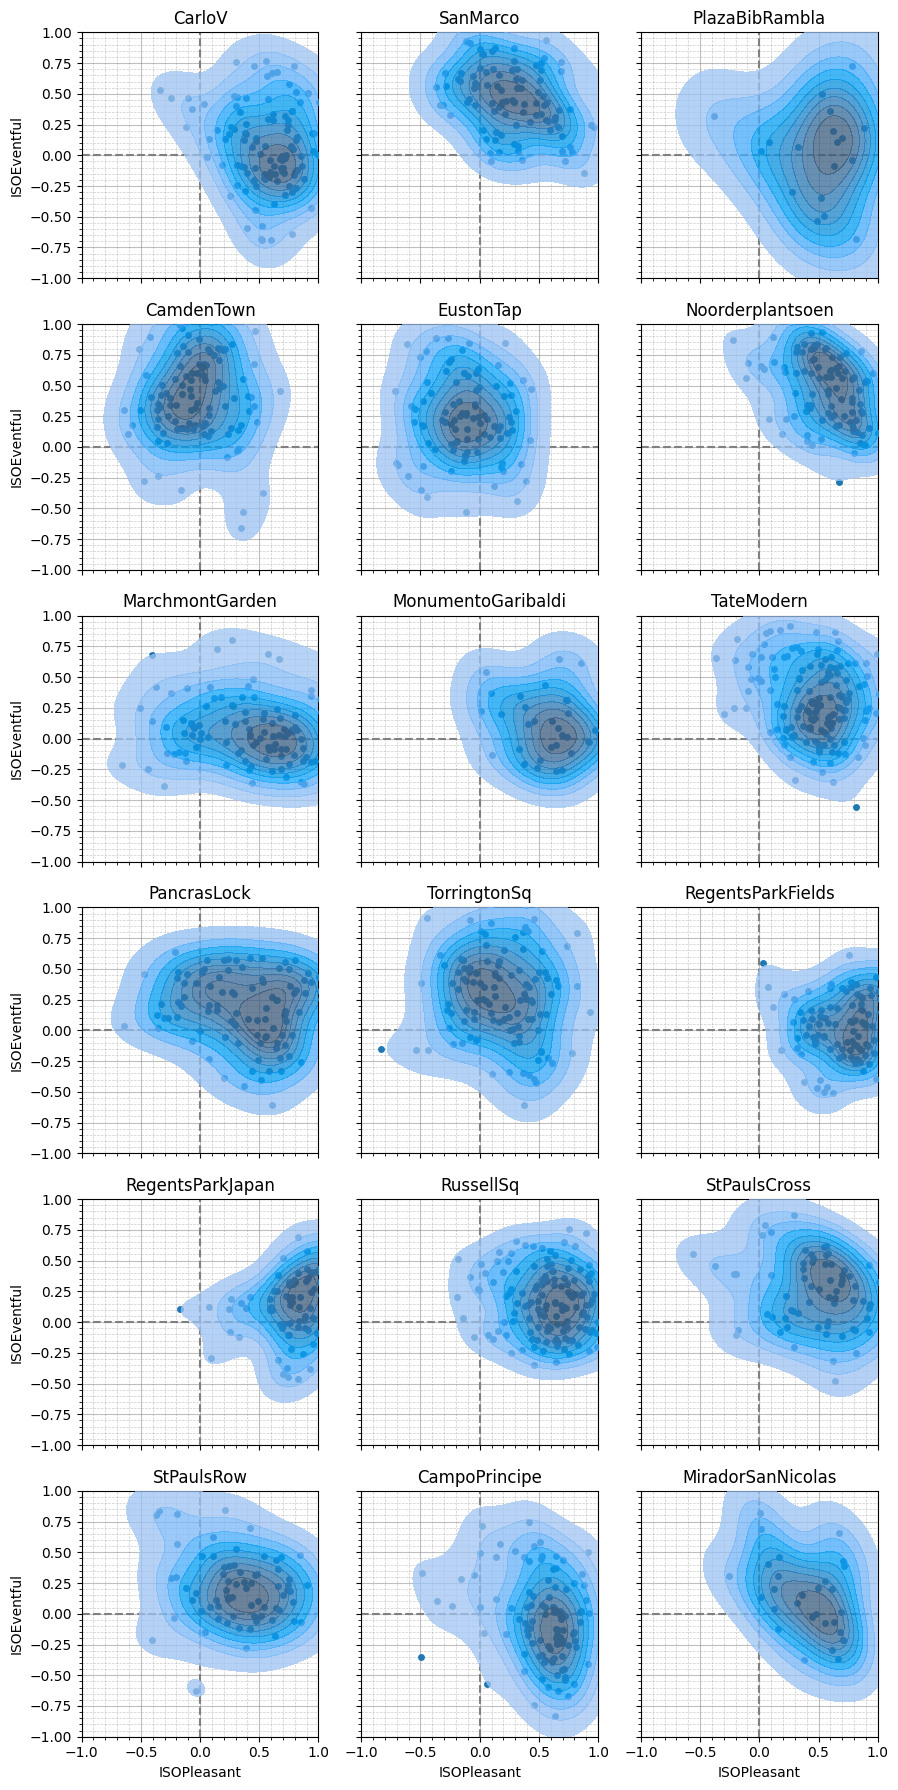

In [7]:
from soundscapy.utils.parameters import PAQ_IDS

for i, row in data.iterrows():
    lang = row["Language"]
    angles = LANGUAGE_ANGLES[lang]
    iso_pl, iso_ev = (
        sspy.surveys.adj_iso_pl(row[PAQ_IDS], angles, scale=4),
        sspy.surveys.adj_iso_ev(row[PAQ_IDS], angles, scale=4),
    )
    data.loc[i, "ISOPleasant"] = iso_pl
    data.loc[i, "ISOEventful"] = iso_ev

fig, axes = plt.subplots(6, 3, figsize=(9, 18), sharex=True, sharey=True)
for i, (loc, ax) in enumerate(zip(data.LocationID.unique(), axes.flatten())):
    sspy.plotting.density(
        data.query(f"LocationID == '{loc}'"),
        ax=ax,
        title=loc,
        # hue='Language',
    )

fig.tight_layout()

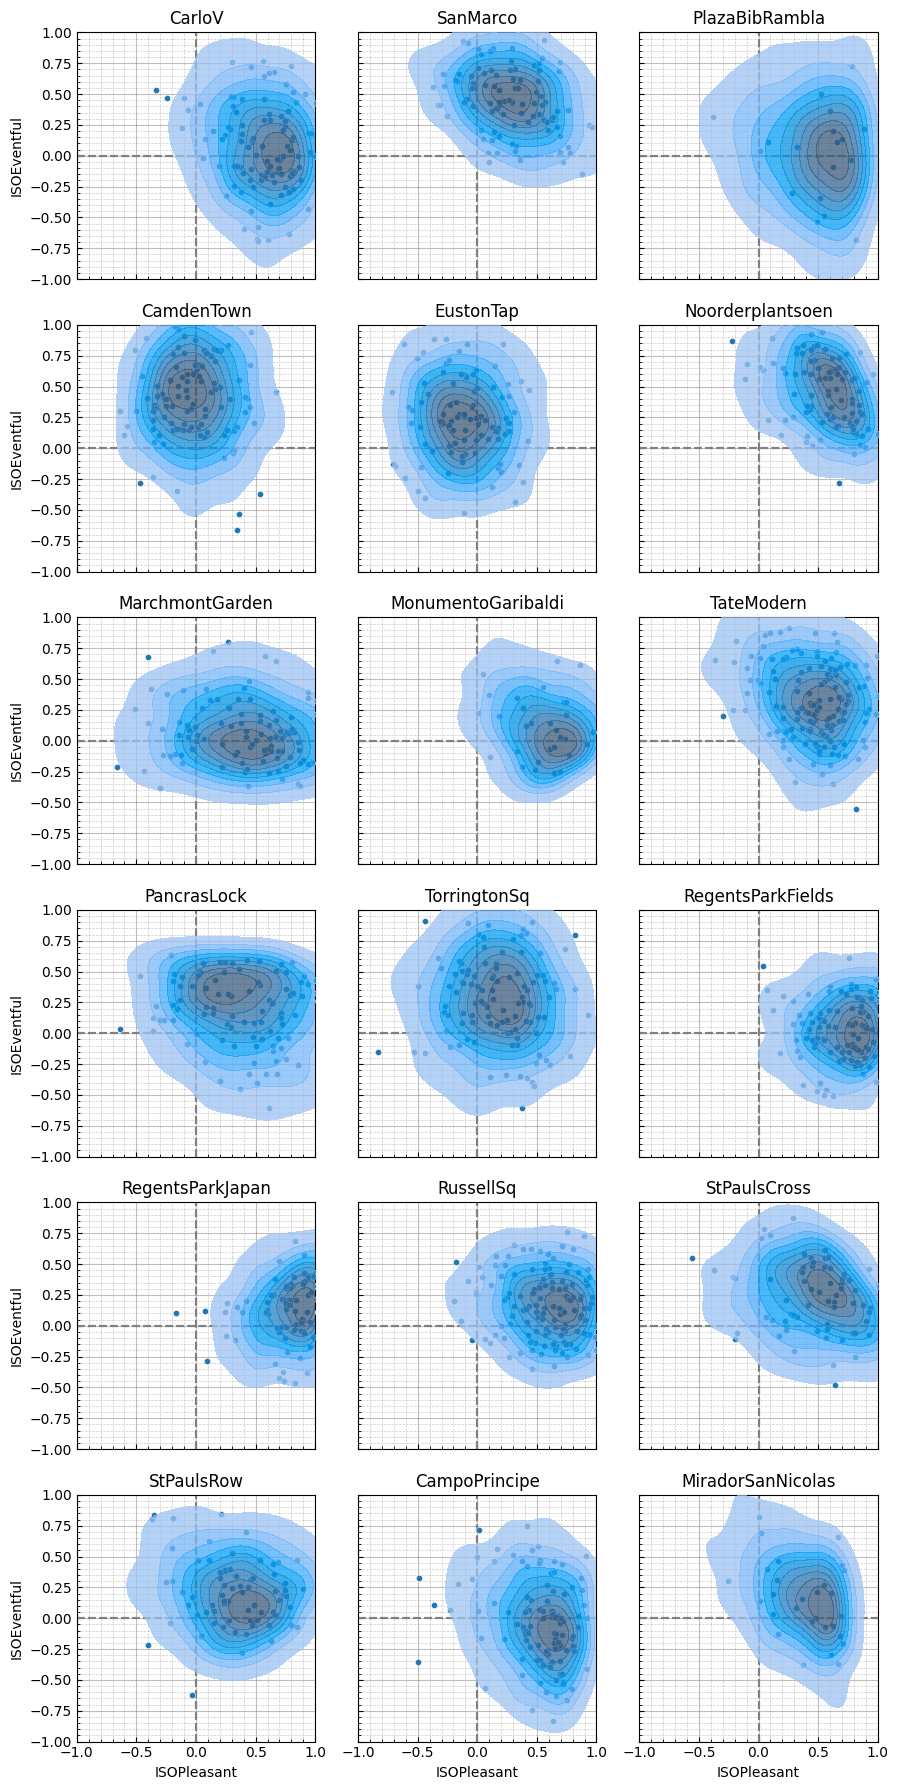

In [8]:
# Plotting distribution density with empirical scatter

fig, axes = plt.subplots(6, 3, figsize=(9, 18), sharex=True, sharey=True)
for i, (loc, ax) in enumerate(zip(data.LocationID.unique(), axes.flatten())):
    loc_msn = MultiSkewNorm()
    loc_msn.fit(
        data=data.query(f"LocationID == '{loc}'")[["ISOPleasant", "ISOEventful"]]
    )
    loc_msn.sample(1000)
    loc_Y = pd.DataFrame(loc_msn.sample_data, columns=["ISOPleasant", "ISOEventful"])

    sspy.plotting.scatter(
        data.query(f"LocationID == '{loc}'"),
        ax=ax,
        title=loc,
    )
    sspy.plotting.density(
        loc_Y,
        ax=ax,
        title=loc,
        incl_scatter=False,
        # hue='Language',
    )

fig.tight_layout()

## The Soundscape Perception Index (SPI)

The SPI works by assessing the assessed (or calculated) distribution of
soundscape responses against a target distribution. This target
distribution represents the goal for the soundscape design. Since we
consider a location’s soundscape perception to be the collective
perception of its users, it is crucial that the target includes both the
central tendency and the distribution.

### Note: Distributions in the circumplex

We should begin by discussing how soundscape circumplex distributions
are defined. The circumplex is defined by two axes: $P_{ISO}$ and
$E_{ISO}$ which are limited to the range $[-1,1]$. Typically the
distribution of collective perception of a soundscape is also not
symmetrical, therefore making it a skewed distribution. A soundscape
distribution is thus a two-dimensional truncated skew-normal
distribution.

The skew-normal distribution is defined by three parameters: location,
scale and shape. The location parameter defines the centre of the
distribution, the scale parameter defines the spread of the
distribution, and the shape parameter defines the skew of the
distribution. The skew-normal distribution is defined as:

$$
f(x; a, \omega, \alpha) = \frac{2}{\omega} \phi \left( \frac{x-a}{\omega} \right) \Phi \left( \alpha \frac{x-a}{\omega} \right)
$$

where $\phi$ and $\Phi$ are the standard normal probability density
function and cumulative distribution function respectively. The
skew-normal distribution is thus a generalisation of the normal
distribution, with the shape parameter $\alpha$ defining the skew. A
positive shape parameter results in a right-skewed distribution, and a
negative shape parameter results in a left-skewed distribution.

Truncated skew-normal distribution:
https://www-tandfonline-com.libproxy.ucl.ac.uk/doi/epdf/10.1080/03610910902936109?needAccess=true

To generate the truncated skew-normal distribution, we use rejection
sampling. This is a method of generating a distribution by sampling from
a simpler distribution and rejecting samples that do not fit the target
distribution. In this case, we sample from a skew-normal distribution
(`scipy.stats.skewnorm`) and reject samples that are outside of the
range $[-1,1]$.

#### Example - Calculating the moments of location’s distribution and generating the equivalent distribution using rejection sampling

In [9]:
test_loc = "SanMarco"
test_data = sspy.isd.select_location_ids(data, test_loc)

msn = MultiSkewNorm()
msn.fit(data=test_data[["ISOPleasant", "ISOEventful"]])

msn.summary()

Fitted from data. n = 95
Direct Parameters:
xi:    [[0.065 0.629]]
omega: [[ 0.149 -0.064]
 [-0.064  0.101]]
alpha: [ 0.791 -0.767]


Centred Parameters:
mean:  [[0.283 0.451]]
sigma: [[ 0.102 -0.026]
 [-0.026  0.07 ]]
skew:  [ 0.136 -0.131]

In [12]:
Y = msn.sample(1000, return_sample=True)
Y = pd.DataFrame(Y, columns=["ISOPleasant", "ISOEventful"])
D, p = msn.ks2ds(test_data[["ISOPleasant", "ISOEventful"]])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sspy.plotting.density(
    test_data,
    ax=axes[0],
    density_type="full",
    title=f"a) Empirical data",
)
sspy.plotting.density(
    Y, ax=axes[1], density_type="full", title="b) MSN sampled distribution\n n sample = 1000"
)
plt.tight_layout()

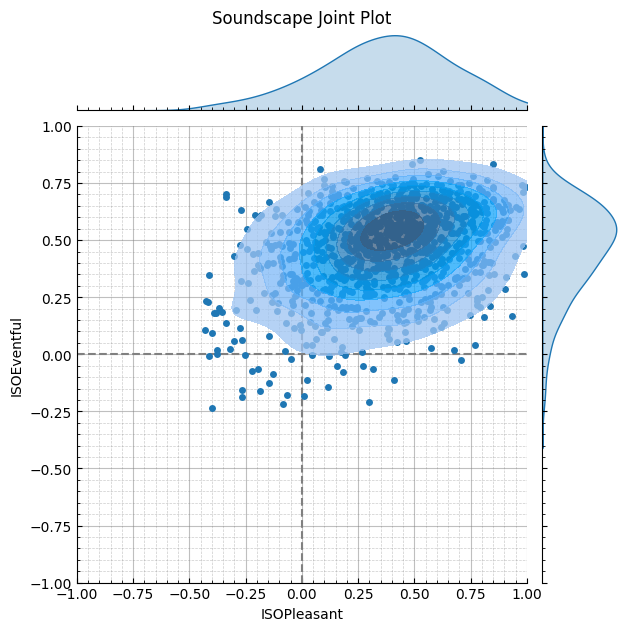

In [8]:
# Universal pleasant target
# target = (
#     np.array([0.5, 0.0]),
#     np.array(
#         [[0.2, 0],
#          [0, 0.2]]),
#     np.array([1, 0])
# )
# target = (
#     np.array([[1.03906292, 0.05335578]]),
#     np.array([[ 0.16551194, -0.04028515],
#               [-0.04028515,  0.08754524]]),
#     np.array([-8.62309592,  1.07337721])
#     )

target = MultiSkewNorm()
target.define_dp(
    xi=np.array([0.5, 0.7]),
    omega=np.array([[0.1, 0.05], [0.05, 0.1]]),
    alpha=np.array([0, -5]),
)
target.sample(1000)
target.sspy_plot()

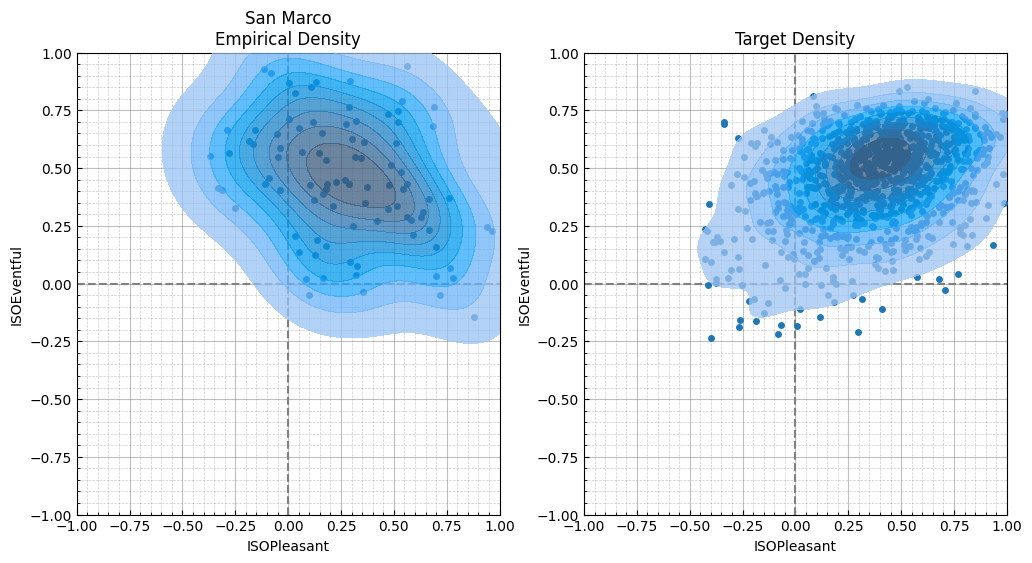

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sspy.plotting.density(
    test_data, incl_scatter=True, title="San Marco\nEmpirical Density", ax=axes[0]
)
sspy.plotting.density(
    pd.DataFrame(target.sample_data, columns=["ISOPleasant", "ISOEventful"]),
    incl_scatter=True,
    title="Target Density",
    ax=axes[1],
)

Once the target is defined, we will generate a set of points that
represent the target distribution.

Now that our target has been defined, we can calculate the SPI for a
given set of responses. We will use the responses from Piazza San Marco
in Venice, Italy, as an example.

In [10]:
test_spi = target.spi(data.query("LocationID == 'SanMarco'")[["ISOPleasant", "ISOEventful"]])
print(f"San Marco SPI = {test_spi}")

San Marco SPI = 70

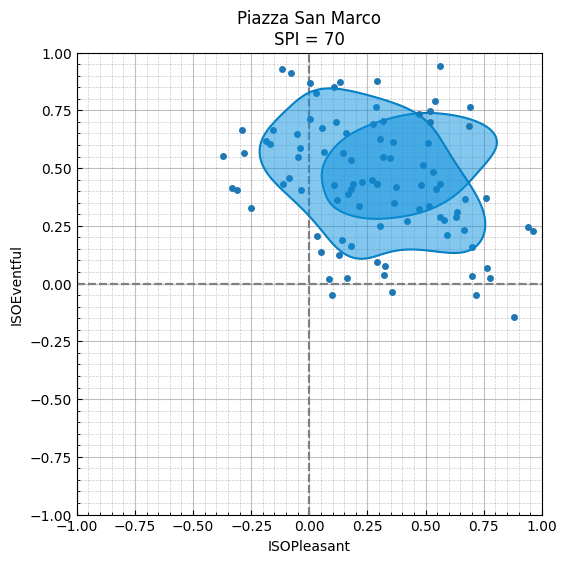

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))

sspy.plotting.density(
    x=target.sample_data[:, 0],
    y=target.sample_data[:, 1],
    ax=ax,
    incl_scatter=False,
    density_type="simple",
    title="",
)
sspy.plotting.density(
    sspy.isd.select_location_ids(data, "SanMarco"),
    ax=ax,
    density_type="simple",
    title=f"Piazza San Marco\nSPI = {test_spi}",
)

We can compare this against another location, such as St Pancras Lock.

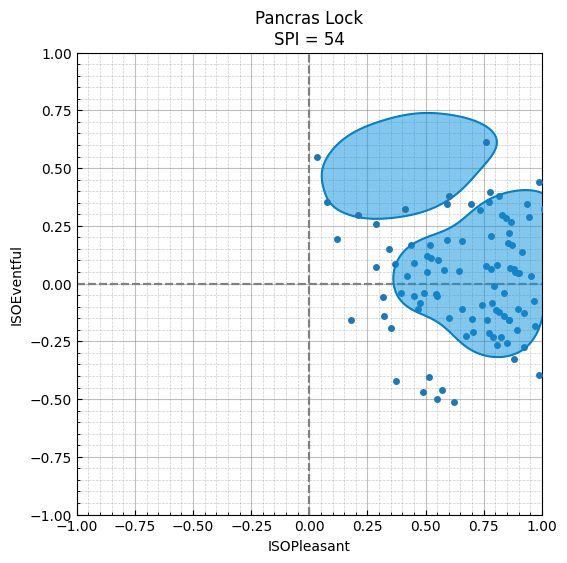

In [12]:
test_spi = target.spi(
    sspy.isd.select_location_ids(data, "PancrasLock")[["ISOPleasant", "ISOEventful"]]
)
fig, ax = plt.subplots(figsize=(6, 6))

sspy.plotting.density(
    x=target.sample_data[:, 0],
    y=target.sample_data[:, 1],
    ax=ax,
    incl_scatter=False,
    density_type="simple",
    title="",
)
sspy.plotting.density(
    sspy.isd.select_location_ids(data, "RegentsParkFields"),
    ax=ax,
    density_type="simple",
    title=f"Pancras Lock\nSPI = {test_spi}",
)

SPI scores assessed against a target should not inherently be considered
a measure of the quality of the soundscape - instead it reflects the
degree to which the soundscape matches the target. A high SPI score does
not necessarily mean that the soundscape is of high quality, but rather
that the soundscape is of high quality *according to the target*.

The $SPI_{bespoke}$ thus provides a method for scoring and ranking the
success of a soundscape design against the designer’s goals. Sticking
with our defined target, we can assess all of the locations in the ISD
and see which locations best match our target.

In [13]:
loc_bespoke = {}
for location in data.LocationID.unique():
    loc_bespoke[location] = target.spi(
        sspy.isd.select_location_ids(data, location)[["ISOPleasant", "ISOEventful"]]
    )

loc_bespoke = pd.DataFrame.from_dict(loc_bespoke, orient="index", columns=["SPI"])
loc_bespoke.sort_values(by="SPI", ascending=False, inplace=True)
loc_bespoke

Assessed against a different target would result in a different ranking:

Fitted from direct parameters.
Direct Parameters:
xi:    [-0.5 -0.5]
omega: [[0.1 0. ]
 [0.  0.2]]
alpha: [-0.85  1.5 ]


None

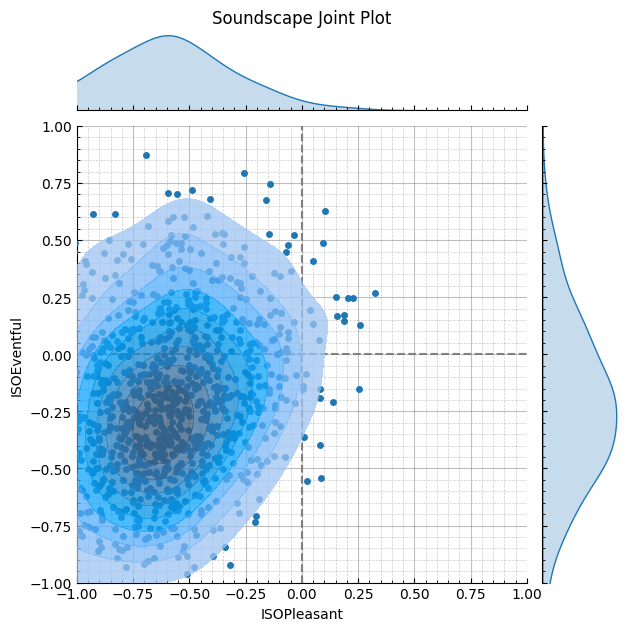

In [14]:
target = MultiSkewNorm()
target.define_dp(
    np.array([-0.5, -0.5]),
    np.array([[0.1, 0], [0, 0.2]]),
    np.array([-0.85, 1.5]),
)
target.summary()

target.sample(n=1000)
target.sspy_plot()

In [15]:
loc_bespoke_2 = {}
for location in data.LocationID.unique():
    loc_bespoke_2[location] = target.spi(
        sspy.isd.select_location_ids(data, location)[["ISOPleasant", "ISOEventful"]]
    )

loc_bespoke_2 = pd.DataFrame.from_dict(loc_bespoke_2, orient="index", columns=["SPI"])
loc_bespoke_2.sort_values(by="SPI", ascending=False, inplace=True)
loc_bespoke_2

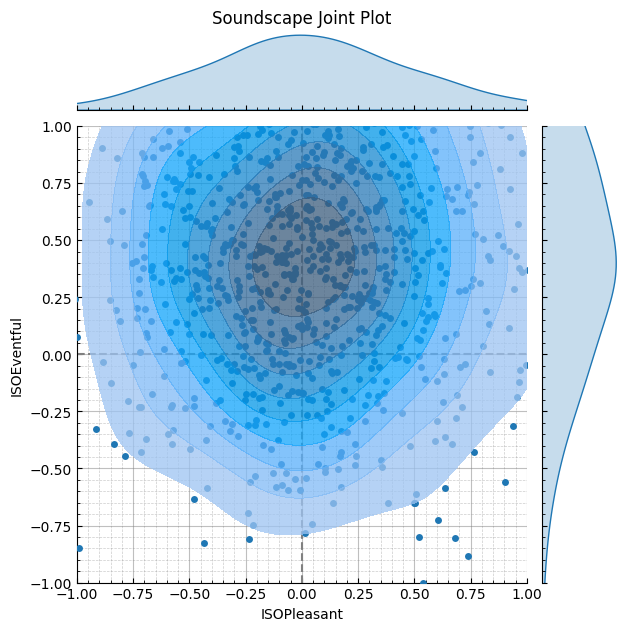

In [16]:
target1 = MultiSkewNorm()
target1.define_dp(
    np.array([-0.5, 0.5]), np.array([[0.1, 0], [0, 0.1]]), np.array([0, 0])
)
target1.sample()

target2 = MultiSkewNorm()
target2.define_dp(np.array([0.5, 0]), np.array([[0.1, 0], [0, 0.2]]), np.array([0, 0]))
target2.sample()

target_mix_y = target1.sample_data + target2.sample_data

target_mix_y = pd.DataFrame(target_mix_y, columns=["ISOPleasant", "ISOEventful"])

sspy.plotting.jointplot(target_mix_y)

------------------------------------------------------------------------

## Defining multi-target SPIs

Above we have defined a single target to assess against. However, it is
often useful to define multiple targets, for instance if different
locations have different design goals. A simple version of this is
clearly quite straightforward - simply define a table with a set of
targets.

------------------------------------------------------------------------

## Defining archetypes

Given the above method of defining and assessing against targets, users
can define their target using whatever criteria they wish. However, a
primary goal of this framework is to enable standard targets or sets of
targets to be empirically defined.

However, it is often useful to define targets based on the architectural
typology of the location. For example, a park may have a different
target to a road.

### Defining an overall quality rating

The overall quality rating is defined as the sum of the
‘Appropriateness’ and ‘Overall Rating’ scores. The overall quality
rating is used to determine the overall quality of the soundscape, for
that respondent.

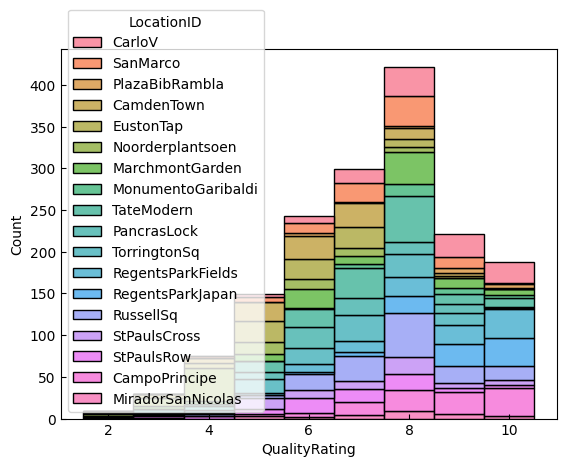

In [17]:
data["QualityRating"] = data.sss02 + data.sss01
# data['QualityRating'] = data.Appropriate + data.sss04 + data.sss05

sns.histplot(
    data=data, x="QualityRating", hue="LocationID", multiple="stack", discrete=True
)

In [18]:
data.LocationID.unique()

array(['CarloV', 'SanMarco', 'PlazaBibRambla', 'CamdenTown', 'EustonTap',
       'Noorderplantsoen', 'MarchmontGarden', 'MonumentoGaribaldi',
       'TateModern', 'PancrasLock', 'TorringtonSq', 'RegentsParkFields',
       'RegentsParkJapan', 'RussellSq', 'StPaulsCross', 'StPaulsRow',
       'CampoPrincipe', 'MiradorSanNicolas'], dtype=object)

In [19]:
# Define some architectural typologies
parks = [
    "RegentsParkFields",
    "RegentsParkJapan",
    "Noorderplantsoen",
    "StPaulsCross",
    "MiradorSanNicolas",
    "RussellSq",
    "LianhuanshanParkForest",
    "Noorderplantsoen",
    "PingshanPark",
    "ZhongshanPark",
]

walkways = [
    "MarchmontGarden",
    "MonumentoGaribaldi",
    "PancrasLock",
    "TateModern",
    "LianhuanshanParkEntrance",
]

squares = [
    "PlazaBibRambla",
    "SanMarco",
    "StPaulsRow",
    "CampoPrincipe",
    "CarloV",
    "DadongSquare",
    "OlympicSquare",
    "ZhongshanSquare",
]

roads = [
    "CamdenTown",
    "EustonTap",
    "TorringtonSq",
    "PingshanStreet",
]

In [20]:
# Assign architectural typologies to each data point
data.loc[data.LocationID.isin(parks), "ArchiType"] = "Park"
data.loc[data.LocationID.isin(walkways), "ArchiType"] = "Walkway"
data.loc[data.LocationID.isin(squares), "ArchiType"] = "Square"
data.loc[data.LocationID.isin(roads), "ArchiType"] = "Road"
data["ArchiType"] = data["ArchiType"].astype("category")

In [21]:
# Classify each point into a high or low soundscape quality
data["TypeSpecificQuality"] = "low"

# By using a quantile-based threshold, we are extracting the top x% of all responses from each typology
for type in data.ArchiType.unique():
    type_threshold = data.query("ArchiType == @type")["QualityRating"].quantile(0.75)
    # type_threshold = type_threshold if type_threshold > 8 else 8
    print(f"Threshold for {type} is {type_threshold}")
    rows = data.query(
        # "ArchiType == @type & QualityRating >= @type_threshold & ISOPleasant > 0", engine="python"
        # "ArchiType == @type & QualityRating >= @type_threshold", engine="python"
        "ArchiType == @type & QualityRating >= 8.0",
        engine="python",
    ).index
    data["TypeSpecificQuality"][rows] = "high"

Threshold for Square is 9.0
Threshold for Road is 7.0
Threshold for Park is 9.0
Threshold for Walkway is 8.0

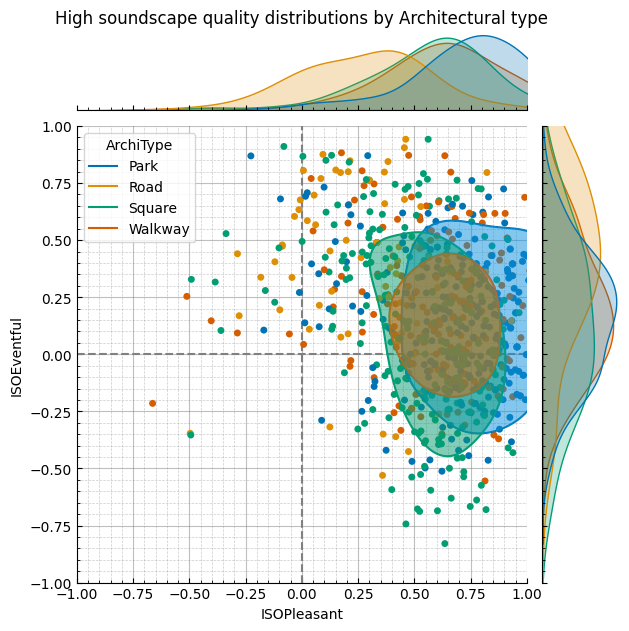

In [22]:
# Plot the high quality responses for each typology
sspy.plotting.jointplot(
    data.query("TypeSpecificQuality == 'high'"),
    hue="ArchiType",
    density_type="simple",
    # incl_scatter=False,
    title="High soundscape quality distributions by Architectural type",
)
plt.show()

In [23]:
# Calculate the distribution models for each type

m_parks = MultiSkewNorm()
m_parks.fit(
    data=data.query("ArchiType == 'Park' & TypeSpecificQuality == 'high'")[
        ["ISOPleasant", "ISOEventful"]
    ]
)
m_parks.sample()

m_road = MultiSkewNorm()
m_road.fit(
    data=data.query("ArchiType == 'Road' & TypeSpecificQuality == 'high'")[
        ["ISOPleasant", "ISOEventful"]
    ]
)
m_road.sample()

m_walkway = MultiSkewNorm()
m_walkway.fit(
    data=data.query("ArchiType == 'Walkway' & TypeSpecificQuality == 'high'")[
        ["ISOPleasant", "ISOEventful"]
    ]
)
m_walkway.sample()

m_square = MultiSkewNorm()
m_square.fit(
    data=data.query("ArchiType == 'Square' & TypeSpecificQuality == 'high'")[
        ["ISOPleasant", "ISOEventful"]
    ]
)
m_square.sample()

In [24]:
y_parks = pd.DataFrame(m_parks.sample_data, columns=["ISOPleasant", "ISOEventful"])
y_parks["ArchiType"] = "Park"
y_road = pd.DataFrame(m_road.sample_data, columns=["ISOPleasant", "ISOEventful"])
y_road["ArchiType"] = "Road"
y_walkway = pd.DataFrame(m_walkway.sample_data, columns=["ISOPleasant", "ISOEventful"])
y_walkway["ArchiType"] = "Walkway"
y_square = pd.DataFrame(m_square.sample_data, columns=["ISOPleasant", "ISOEventful"])
y_square["ArchiType"] = "Square"

gend_df = pd.concat([y_parks, y_road, y_walkway, y_square])

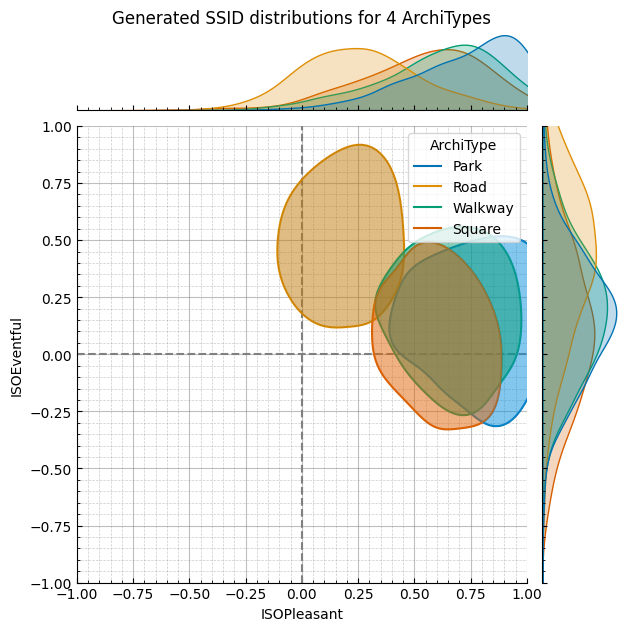

In [25]:
# plot
sspy.plotting.jointplot(
    gend_df,
    hue="ArchiType",
    density_type="simple",
    incl_scatter=False,
    title="Generated SSID distributions for 4 ArchiTypes",
)
plt.show()

In [26]:
# Put it all together
loc = "RegentsParkJapan"
architype = "Park"
res = m_parks.spi(
    data.query("LocationID == @loc")[["ISOPleasant", "ISOEventful"]]
)
print(f"{loc} SPI_{architype}: {res}")

loc = "MarchmontGarden"
architype = "Park"
res = m_parks.spi(
    data.query("LocationID == @loc")[["ISOPleasant", "ISOEventful"]]
)
print(f"{loc} SSID_{architype}: {res}")

loc = "EustonTap"
architype = "Road"
res = m_road.spi(
    data.query("LocationID == @loc")[["ISOPleasant", "ISOEventful"]]
)
print(f"{loc} SSID_{architype}: {res}")

RegentsParkJapan SPI_Park: 84
MarchmontGarden SSID_Park: 63
EustonTap SSID_Road: 50

In [27]:
# fig, axes = plt.subplots(4, 3, figsize=(12, 16))

# for i, loc in enumerate(data.LocationID.unique()):
#     if loc in data.LocationID.unique():
#         utils.spi_plot(data, gend_df, "Park", loc, ax=axes.flatten()[i])

# plt.tight_layout()
# plt.show()

In [28]:
# fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# for i, loc in enumerate(roads):
#     utils.spi_plot(data, gend_df, "Road", loc, ax=axes.flatten()[i])
# plt.tight_layout()
# plt.show()

In [29]:
# fig, axes = plt.subplots(6, 3, figsize=(9, 18))
# for i, loc in enumerate(data.LocationID.unique()):
#     try:
#         archi_type = data.query("LocationID == @loc")["ArchiType"].iloc[0]
#         utils.spi_plot(data, gend_df, archi_type, loc, ax=axes.flatten()[i])
#     except:
#         print(f"Error with {loc}")
#         pass
# plt.tight_layout()
# plt.show()

## MLE for fitting the target distribution

Non-derivative/non-gradient based methods - evolutionary algorithms -
NSGA-II - Simulated annealing -

Gradient-based approaches - Giorgious recommends avoiding these

In [30]:
quality = pd.DataFrame(
    data.groupby("LocationID")["QualityRating"].mean().sort_values(ascending=False)
)
quality["Rank"] = range(1, len(quality) + 1)
quality

In [31]:
quality = pd.DataFrame(
    data.groupby("LocationID")["QualityRating"].mean().sort_values(ascending=False)
)
quality["Rank"] = range(1, len(quality) + 1)
quality = quality.sort_index()["Rank"].copy()


def target_success(
    target: MultiSkewNorm, ranking: pd.Series, data: pd.DataFrame, n_sample=1000
):
    from scipy.stats import spearmanr

    assert len(ranking) == len(data.LocationID.unique())
    assert target.sample_data is not None, "Target has not been sampled"

    spis = {}
    for location in data.LocationID.unique():
        # test_spi = utils.spi(
        #     sspy.isd.select_location_ids(data, location)[["ISOPleasant", "ISOEventful"]],
        #     target.sample_data,
        # )
        test_spi = target.spi(
            sspy.isd.select_location_ids(data, location)[["ISOPleasant", "ISOEventful"]]
        )
        spis[location] = test_spi

    spi_ranks = pd.DataFrame.from_dict(spis, orient="index", columns=["SPI"])
    spi_ranks.sort_values(by="SPI", ascending=False, inplace=True)
    spi_ranks["Rank"] = range(1, len(spi_ranks) + 1)
    ranks = spi_ranks.sort_index()["Rank"]

    spearman = spearmanr(ranking, ranks)
    weighted_spi = sum([(1 / rank) * spi for rank, spi in zip(ranks, spi_ranks["SPI"])])

    return spearman, weighted_spi, spi_ranks


tgt = MultiSkewNorm()
tgt.define_dp(
    np.array([0.5, 0.7]),
    np.array([[0.1, 0.05], [0.05, 0.1]]),
    np.array([0, -5]),
)
tgt.sample()
target_success(tgt, quality, data)

(SignificanceResult(statistic=-0.4984520123839009, pvalue=0.03525363586497097),
 138.96230721892485,
                     SPI  Rank
 SanMarco             74     1
 TateModern           63     2
 StPaulsCross         62     3
 PancrasLock          57     4
 TorringtonSq         56     5
 Noorderplantsoen     56     6
 StPaulsRow           49     7
 MiradorSanNicolas    49     8
 RussellSq            47     9
 CamdenTown           44    10
 CarloV               41    11
 MonumentoGaribaldi   39    12
 PlazaBibRambla       37    13
 MarchmontGarden      36    14
 EustonTap            33    15
 CampoPrincipe        33    16
 RegentsParkFields    28    17
 RegentsParkJapan     27    18)

In [32]:
import optimize_target

optimize_target.target_success(tgt, quality, data, "LocationID")

(SignificanceResult(statistic=-0.4674922600619195, pvalue=0.05043751945104438),
 138.98730721892488,
                     SPI  Rank
 SanMarco             74     1
 TateModern           63     2
 StPaulsCross         62     3
 PancrasLock          57     4
 TorringtonSq         56     5
 Noorderplantsoen     56     6
 StPaulsRow           49     7
 MiradorSanNicolas    49     8
 RussellSq            47     9
 CamdenTown           44    10
 CarloV               41    11
 MonumentoGaribaldi   39    12
 PlazaBibRambla       37    13
 MarchmontGarden      36    14
 CampoPrincipe        33    15
 EustonTap            33    16
 RegentsParkFields    28    17
 RegentsParkJapan     27    18,
 MultiSkewNorm(dp=Direct Parameters:
 xi:    [0.5 0.7]
 omega: [[0.1  0.05]
  [0.05 0.1 ]]
 alpha: [ 0 -5]))

In [33]:
print("\nTarget\n", target)
print(target_success(target, quality, data)[0:2])

print("\nTarget 1\n", target1)
print(target_success(target1, quality, data)[0:2])

print("\nTarget 2\n", target2)
print(target_success(target2, quality, data)[0:2])

print("\nParks\n", m_parks)
print(target_success(m_parks, quality, data)[0:2])

print("\nRoad\n", m_road)
print(target_success(m_road, quality, data)[0:2])

print("\nSquare\n", m_square)
print(target_success(m_square, quality, data)[0:2])

print("\nWalkway\n", m_walkway)
print(target_success(m_walkway, quality, data)[0:2])


Target
 MultiSkewNorm(dp=Direct Parameters:
xi:    [-0.5 -0.5]
omega: [[0.1 0. ]
 [0.  0.2]]
alpha: [-0.85  1.5 ])
(SignificanceResult(statistic=-0.42414860681114547, pvalue=0.0793889023946049), 53.749148400618985)

Target 1
 MultiSkewNorm(dp=Direct Parameters:
xi:    [-0.5  0.5]
omega: [[0.1 0. ]
 [0.  0.1]]
alpha: [0 0])
(SignificanceResult(statistic=-0.7069143446852425, pvalue=0.001036757704756384), 73.58191008338068)

Target 2
 MultiSkewNorm(dp=Direct Parameters:
xi:    [0.5 0. ]
omega: [[0.1 0. ]
 [0.  0.2]]
alpha: [0 0])
(SignificanceResult(statistic=0.5562435500515995, pvalue=0.016518403054404888), 223.52006718771426)

Parks
 MultiSkewNorm(dp=Direct Parameters:
xi:    [[1.039 0.053]]
omega: [[ 0.166 -0.04 ]
 [-0.04   0.088]]
alpha: [-8.623  1.073])
(SignificanceResult(statistic=0.6367389060887513, pvalue=0.004489848099432227), 190.83963079404256)

Road
 MultiSkewNorm(dp=Direct Parameters:
xi:    [[0.009 0.771]]
omega: [[ 0.142 -0.104]
 [-0.104  0.275]]
alpha: [ 3.99  -4.438])
(

In [34]:
park_data = data.query("ArchiType == 'Park'")
park_quality = pd.DataFrame(
    park_data.groupby("LocationID")["QualityRating"].mean().sort_values(ascending=False)
)
park_quality["Rank"] = range(1, len(park_quality) + 1)
park_quality = park_quality.sort_index()["Rank"].copy()

print("\nParks\n", m_parks)
print(target_success(m_parks, park_quality, park_data)[0:2])

square_data = data.query("ArchiType != 'Park'")
square_quality = pd.DataFrame(
    square_data.groupby("LocationID")["QualityRating"]
    .mean()
    .sort_values(ascending=False)
)
square_quality["Rank"] = range(1, len(square_quality) + 1)
square_quality = square_quality.sort_index()["Rank"].copy()

print("\nSquares\n", m_square)
print(target_success(m_square, square_quality, square_data)[0:2])


Parks
 MultiSkewNorm(dp=Direct Parameters:
xi:    [[1.039 0.053]]
omega: [[ 0.166 -0.04 ]
 [-0.04   0.088]]
alpha: [-8.623  1.073])
(SignificanceResult(statistic=0.8285714285714287, pvalue=0.04156268221574334), 155.3)

Squares
 MultiSkewNorm(dp=Direct Parameters:
xi:    [[ 0.865 -0.131]]
omega: [[ 0.17  -0.106]
 [-0.106  0.208]]
alpha: [-3.175  0.938])
(SignificanceResult(statistic=0.6573426573426573, pvalue=0.020185498509854103), 216.6029942279942)

In [35]:
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm_notebook as tqdm

def _omega_is_pos_def(omega: np.ndarray) -> bool:
    return np.all(np.linalg.eigvals(omega) > 0)

def _omega_is_symmetric(omega: np.ndarray) -> bool:
    return np.allclose(omega, omega.T)

param_grid = {
    "omega_0x": np.linspace(0, 0.5, 10),
    "omega_0y": np.linspace(-1, 1, 10),
    "omega_1x": np.linspace(-1, 1, 10),
    "omega_1y": np.linspace(0, 0.5, 10),
}

grid = ParameterGrid(param_grid)
grid_list = list(grid)

omegas = []
for params in tqdm(grid_list):
    omega = np.array([
        [params["omega_0x"], params["omega_0y"]], 
        [params["omega_1x"], params["omega_1y"]]
        ])
    if _omega_is_pos_def(omega) and _omega_is_symmetric(omega):
        omegas.append(omega)


In [36]:
len(omegas)

187

In [37]:
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm_notebook as tqdm
from tqdm_pathos import tqdm_pathos

def try_target(params, n=100):
    tgt = MultiSkewNorm()
    try:
        # Catch the errors raised by DirectParams.validate()
        # If dp doesn't pass validation,xi don't append it to the list
        tgt.define_dp(
            xi = np.array([params["xi_x"], params["xi_y"]]),
            omega = params["omega"],
            alpha = np.array([params["alpha_x"], params["alpha_y"]]),
        )
    except AssertionError:
        return None

    tgt.sample(n=n)
    return tgt

param_grid = {
    "xi_x": np.linspace(-1, 1, 5),
    "xi_y": np.linspace(-1, 1, 5),
    # "omega_0x": np.linspace(0, 0.5, 10),
    # "omega_0y": np.linspace(-1, 1, 10),
    # "omega_1x": np.linspace(-1, 1, 10),
    # "omega_1y": np.linspace(0, 0.5, 10),
    "omega": omegas,
    "alpha_x": np.linspace(-2, 2, 5),
    "alpha_y": np.linspace(-2, 2, 5),
}
grid = ParameterGrid(param_grid)
grid_list = list(grid)

# targets = []
# for params in tqdm(grid_list):
#     tgt = try_target(params, n=250)
#     if tgt is not None:
#         targets.append(tgt)

targets = tqdm_pathos.map(try_target, grid_list)

print(len(targets))

116875

### General Quality

In [53]:
# r_res = np.array([])
# wspi_res = np.array([])
# ranks_res = []

# for target in tqdm(targets):
#     res = target_success(target, quality, data)
#     r_res = np.append(r_res, res[0][0])
#     wspi_res = np.append(wspi_res, res[1])
#     ranks_res.append(res[2])

In [38]:
r_res, wspi_res, targets_res = optimize_target.run_grid(targets, quality, data, "LocationID")

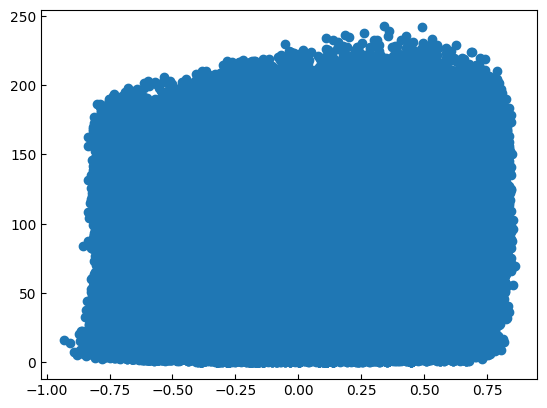

In [39]:
plt.plot(r_res, wspi_res, "o")

0.7894736842105263
Fitted from direct parameters.
Direct Parameters:
xi:    [ 0.5 -0.5]
omega: [[0.056 0.111]
 [0.111 0.444]]
alpha: [1. 2.]


None
None

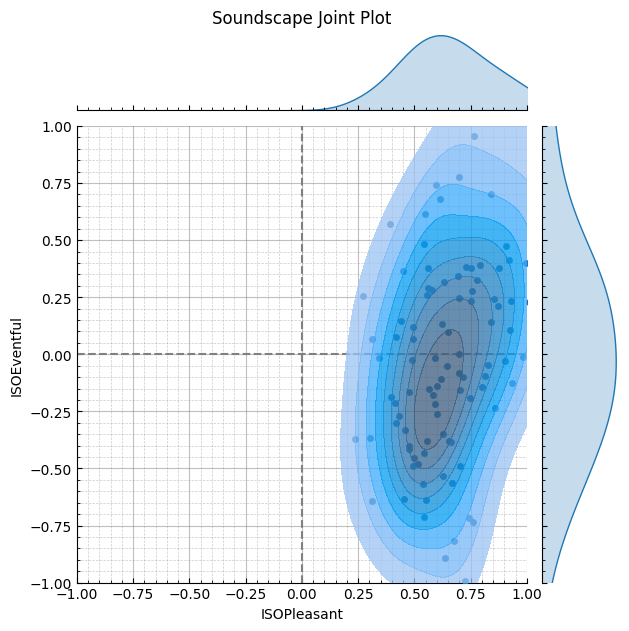

In [40]:
comb_res = [r_res[i] * wspi_res[i] for i in range(len(r_res))]
best_target = targets[np.argmax(comb_res)]
print(r_res[np.argmax(comb_res)])

print(best_target.summary())
best_target.sspy_plot()

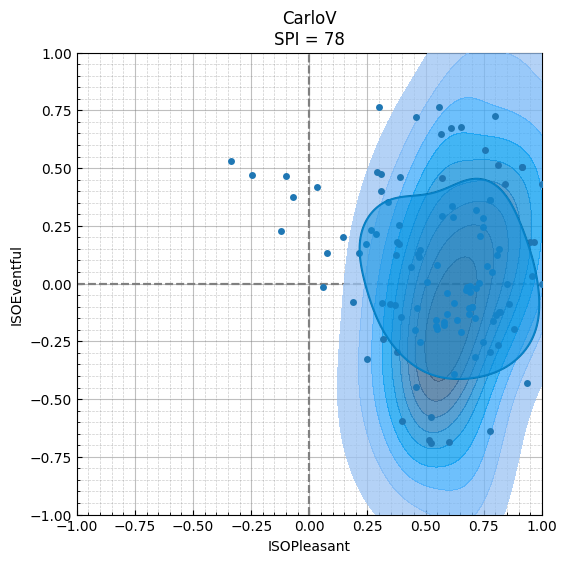

In [44]:
fig, ax = plt.subplots(figsize=(6, 6))

sspy.plotting.density(
    x=best_target.sample_data[:, 0], y=best_target.sample_data[:, 1], ax=ax, incl_scatter=False, density_type="full", title=""
)

sspy.plotting.density(
    sspy.isd.select_location_ids(data, "CarloV"),
    ax=ax,
    density_type="simple",
    title=f"CarloV\nSPI = {best_target.spi(sspy.isd.select_location_ids(data, 'CarloV')[['ISOPleasant', 'ISOEventful']])}",
)

In [42]:
optimize_target.target_success(best_target, quality, data, "LocationID")

(SignificanceResult(statistic=0.7894736842105263, pvalue=9.781072774060512e-05),
 210.24482037570274,
                     SPI  Rank
 CarloV               78     1
 PlazaBibRambla       75     2
 CampoPrincipe        74     3
 RussellSq            72     4
 MonumentoGaribaldi   70     5
 RegentsParkFields    67     6
 RegentsParkJapan     62     7
 MarchmontGarden      61     8
 PancrasLock          57     9
 StPaulsCross         55    10
 TateModern           50    11
 MiradorSanNicolas    50    12
 StPaulsRow           47    13
 Noorderplantsoen     44    14
 SanMarco             32    15
 TorringtonSq         31    16
 CamdenTown           15    17
 EustonTap            10    18,
 MultiSkewNorm(dp=Direct Parameters:
 xi:    [ 0.5 -0.5]
 omega: [[0.056 0.111]
  [0.111 0.444]]
 alpha: [1. 2.]))

In [43]:
quality.sort_values()

LocationID
RegentsParkJapan       1
CampoPrincipe          2
PlazaBibRambla         3
RegentsParkFields      4
CarloV                 5
MonumentoGaribaldi     6
RussellSq              7
SanMarco               8
MiradorSanNicolas      9
TateModern            10
MarchmontGarden       11
StPaulsCross          12
TorringtonSq          13
StPaulsRow            14
PancrasLock           15
CamdenTown            16
EustonTap             17
Noorderplantsoen      18
Name: Rank, dtype: int64

### Park Quality

In [46]:
r_res, wspi_res, targets_res = optimize_target.run_grid(targets, park_quality, data, "LocationID")


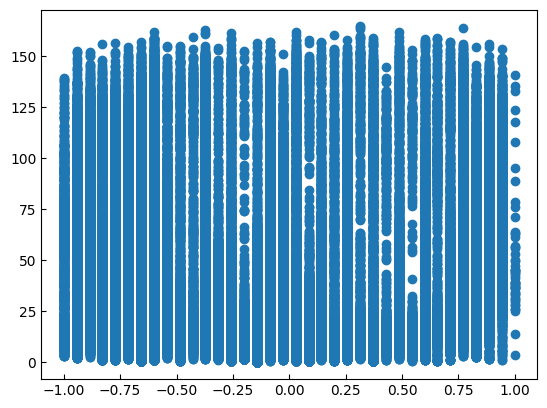

In [47]:
plt.plot(r_res, wspi_res, "o")

0.942857142857143
Fitted from direct parameters.
Direct Parameters:
xi:    [0.5 0.5]
omega: [[ 0.278 -0.111]
 [-0.111  0.278]]
alpha: [ 1. -2.]


None
None

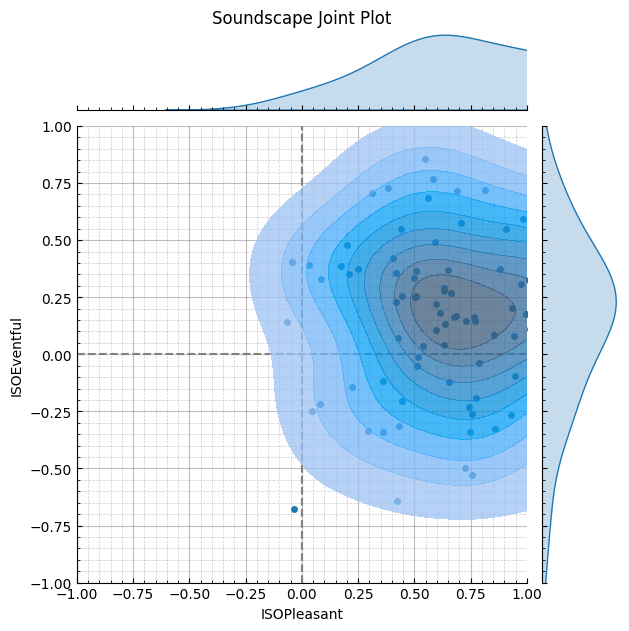

In [50]:
comb_res = [r_res[i] * wspi_res[i] for i in range(len(r_res))]
best_target = targets[np.argmax(comb_res)]
print(r_res[np.argmax(comb_res)])

print(best_target.summary())
best_target.sspy_plot()

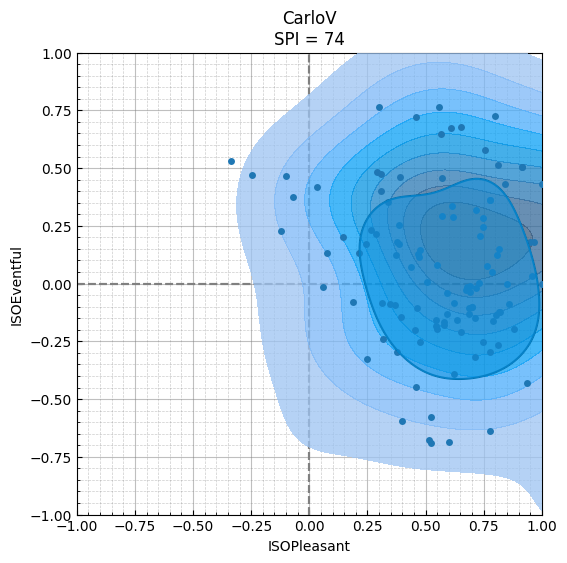

In [51]:
fig, ax = plt.subplots(figsize=(6, 6))

sspy.plotting.density(
    x=best_target.sample_data[:, 0], y=best_target.sample_data[:, 1], ax=ax, incl_scatter=False, density_type="full", title=""
)

sspy.plotting.density(
    sspy.isd.select_location_ids(data, "CarloV"),
    ax=ax,
    density_type="simple",
    title=f"CarloV\nSPI = {best_target.spi(sspy.isd.select_location_ids(data, 'CarloV')[['ISOPleasant', 'ISOEventful']])}",
)

### Not Park Quality

In [52]:
r_res, wspi_res, targets_res = optimize_target.run_grid(targets, square_quality, square_data, "LocationID")


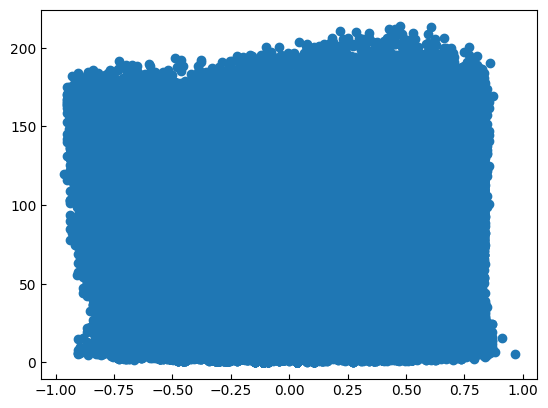

In [53]:
plt.plot(r_res, wspi_res, "o")

0.8601398601398602
Fitted from direct parameters.
Direct Parameters:
xi:    [0.5 0. ]
omega: [[ 0.056 -0.111]
 [-0.111  0.444]]
alpha: [1. 1.]


None
None

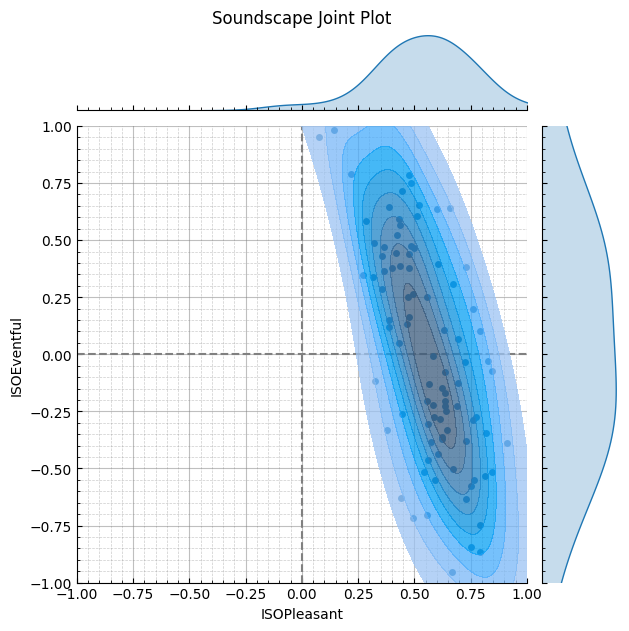

In [54]:
comb_res = [r_res[i] * wspi_res[i] for i in range(len(r_res))]
best_target = targets[np.argmax(comb_res)]
print(r_res[np.argmax(comb_res)])

print(best_target.summary())
best_target.sspy_plot()

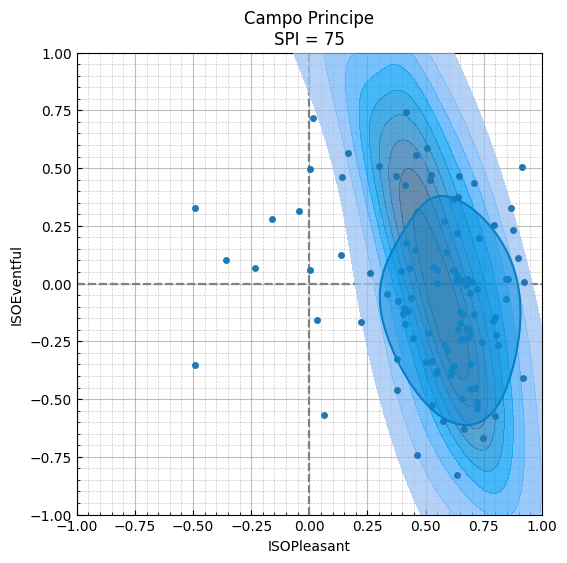

In [58]:
fig, ax = plt.subplots(figsize=(6, 6))

sspy.plotting.density(
    x=best_target.sample_data[:, 0], y=best_target.sample_data[:, 1], ax=ax, incl_scatter=False, density_type="full", title=""
)

sspy.plotting.density(
    sspy.isd.select_location_ids(data, "CampoPrincipe"),
    ax=ax,
    density_type="simple",
    title=f"Campo Principe\nSPI = {best_target.spi(sspy.isd.select_location_ids(data, 'CampoPrincipe')[['ISOPleasant', 'ISOEventful']])}",
)

In [56]:
target_success(best_target, square_quality, square_data)

(SignificanceResult(statistic=0.8601398601398602, pvalue=0.0003316683391269209),
 190.0364357864358,
                     SPI  Rank
 CampoPrincipe        75     1
 PlazaBibRambla       72     2
 CarloV               70     3
 MarchmontGarden      67     4
 MonumentoGaribaldi   64     5
 TateModern           63     6
 PancrasLock          62     7
 StPaulsRow           58     8
 SanMarco             49     9
 TorringtonSq         44    10
 CamdenTown           21    11
 EustonTap            14    12)

In [57]:
square_quality.sort_values()

LocationID
CampoPrincipe          1
PlazaBibRambla         2
CarloV                 3
MonumentoGaribaldi     4
SanMarco               5
TateModern             6
MarchmontGarden        7
TorringtonSq           8
StPaulsRow             9
PancrasLock           10
CamdenTown            11
EustonTap             12
Name: Rank, dtype: int64